In [10]:
import numpy as np

from ffnavpy.analysis import run_analysis
from ffnavpy.plotting import save_plots, plot_results, plot_control, plot_position
from ffnavpy.satellite import CommandSequence
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simulation configuration

In [11]:
6600*np.sin(10*np.pi/180)

1146.0779726017402

In [12]:
# Initial state of deputy [km, km/s]

x0 = np.array(
    [
        1.5097937630e11,
        -4.6840029080e-08,
        1.8369701987e-08,
        -6.0196990433e-15,
        1.5667113355e02,
        -1.1858897424e02,
    ]
)  # [m / m/s], 'P1-IdealSynodic', Sun-Earth

x0 = np.array([ 1.51221927e+11,
                1.46847862e+07,
                3.13475840e+08,
               -1.76215637e+01,
               -1.53877076e+02,
               -1.02571790e+00])

# Initial relative state [m, m/s]
dx0 = np.array([6600, 1100, 0, 0*2*(0.5-np.random.random())*1e-4, 0*2*(0.5-np.random.random())*1e-4, 0*2*(0.5-np.random.random())*1e-4])



# State commanded
x_target = np.array([6600, 1100, 0, 0, 0, 0])

# Duration of the simulation [s]
tf = 3600*2

# Time step of simulation [s]
dT = 1

configOBC = {'x_target': x_target, 
             'estimation_mode': 'kalman',
             'control_mode': 'LQR',
             'Tsk': 1,
             'sigma_r0': 1e-6,
             'sigma_v0': 1e-6,
             'sigma_x': 1e-4,
             'sigma_y': 1e-4,
             'sigma_z': 1e-4,
             'period': 60,
             'horizon': 10,
             'u_threshold_v': np.ones(3) * 0.00015,
             'u_threshold_a': np.ones(3) * 0.00015,
             'x_threshold': np.concatenate([0.01*np.ones(3),0.0001*np.ones(3)]),
             'thrust_nominal' : 1e-3,
             'tb_min' : 0.01,
             'tb_lower_limit': 0.008,
             'X0' : dx0
             }

configSim = {'sigma_distance': 1e-04, 'sigma_angle': 0.25}

cmd_sequence = CommandSequence()
# cmd_sequence.add_command('change_control_mode', 'LQR', 60)
# cmd_sequence.add_command('change_estimation_mode', 'kalman', 3000)
# cmd_sequence.add_command('change_control_mode', 'LQR', 4800)
# cmd_sequence.add_command('change_control_mode', 'ETM', 3600*2)

# Create predefined case for chief-deputy formation
# simcase = ChiefDeputyCase(LiteBird, CalSat, cmd_sequence=cmd_sequence, configOBC=ConfigOBC)



### LQR analysis

In [13]:
sim_lqr = run_analysis(x0, dx0, x_target, tf, dT, configOBC, configSim, cmd_seq=cmd_sequence)

100%|██████████| 7201/7201 [02:02<00:00, 58.61it/s]


### MPC analysis

In [14]:
configOBC['control_mode'] = 'MPC'
cmd_sequence = CommandSequence()
# cmd_sequence.add_command('change_control_mode', 'MPC', 60)

In [15]:
sim_mpc = run_analysis(x0, dx0, x_target, tf, dT, configOBC, configSim, cmd_seq=cmd_sequence)

100%|██████████| 7201/7201 [01:25<00:00, 83.94it/s]


In [16]:
xdstyle = {
        "color": "b",
        "linestyle": "-",
        "linewidth": 1.2,
        # "marker": "+",
        "markersize": 4,
    }

fontdict = {'family': 'serif',
        'weight': 'normal',
        'size': 12,
        }

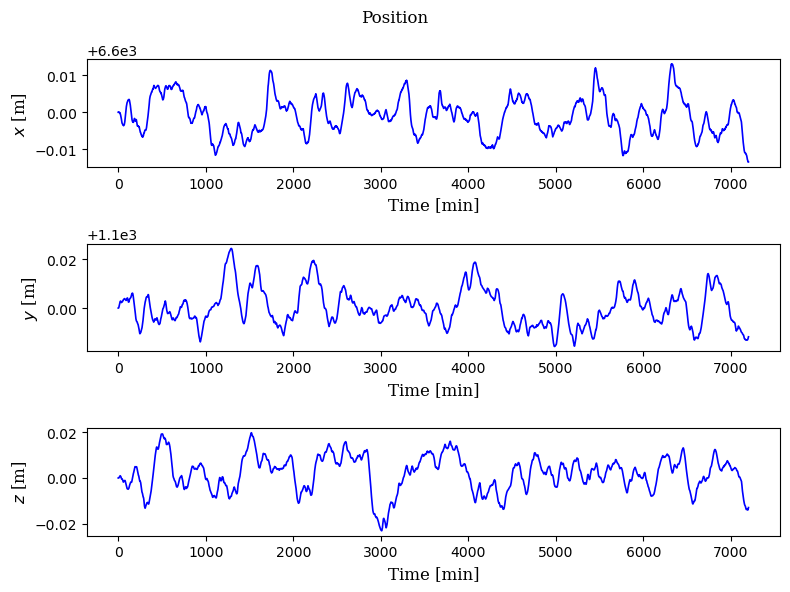

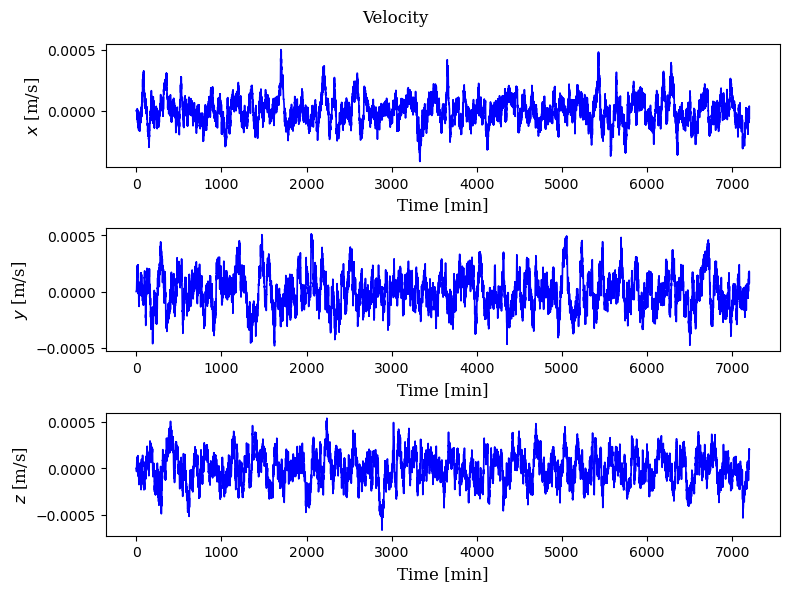

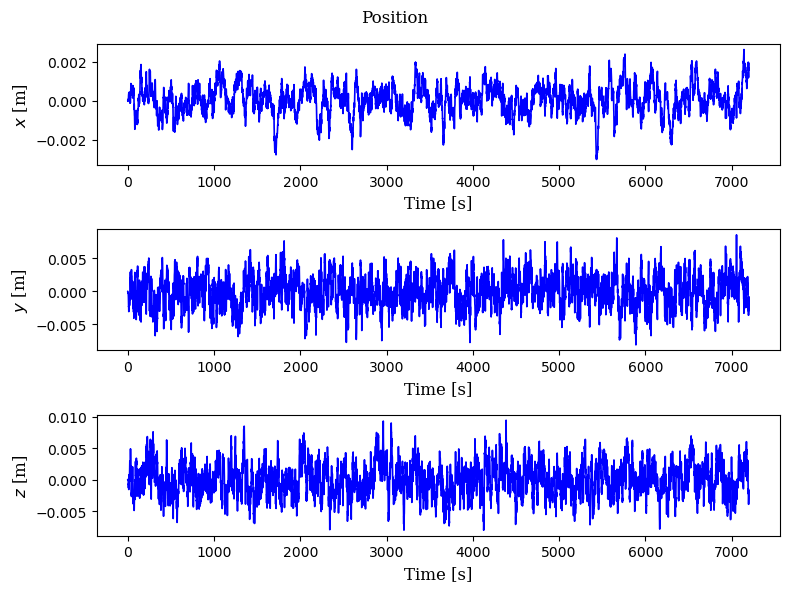

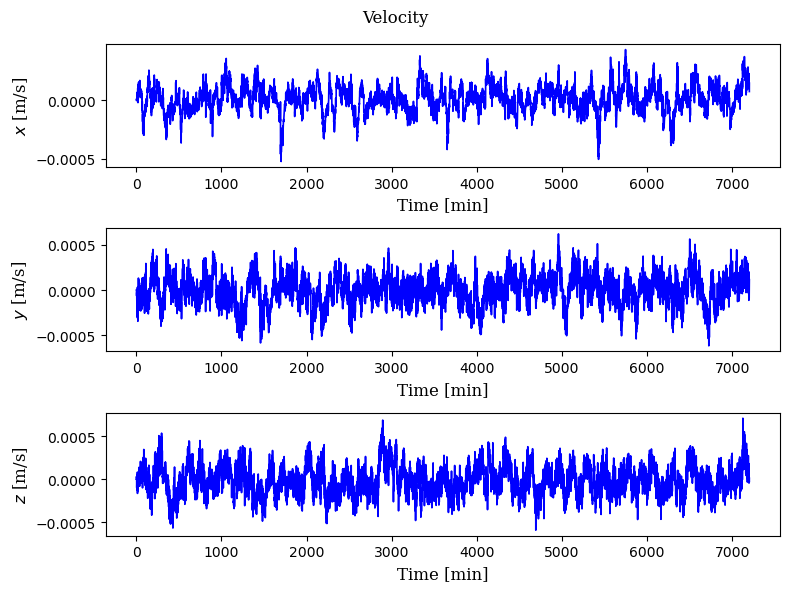

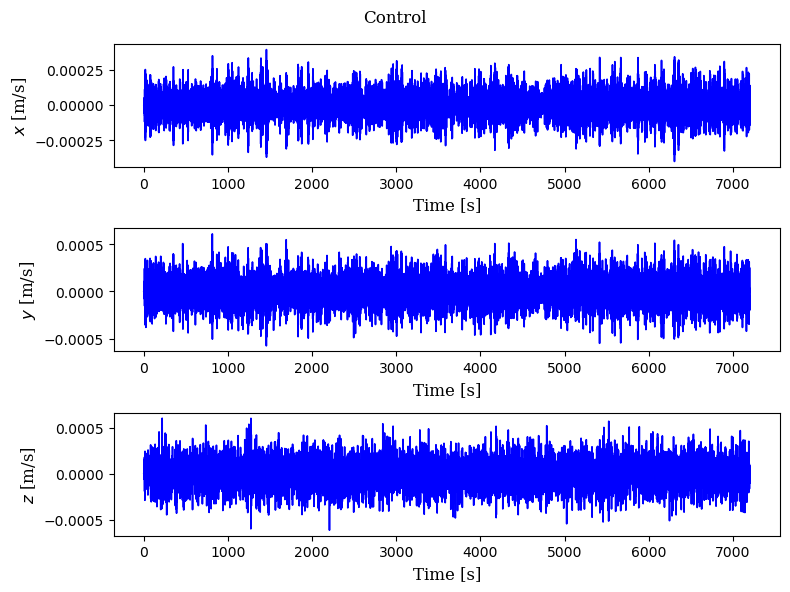

In [17]:
fig_dict_lqr = plot_results(sim_lqr, xdstyle, fontdict, r_units=("min", "m"), v_units=("min", "m/s"))
save_plots(fig_dict_lqr, "calibration_lqr", "calibration_cs")

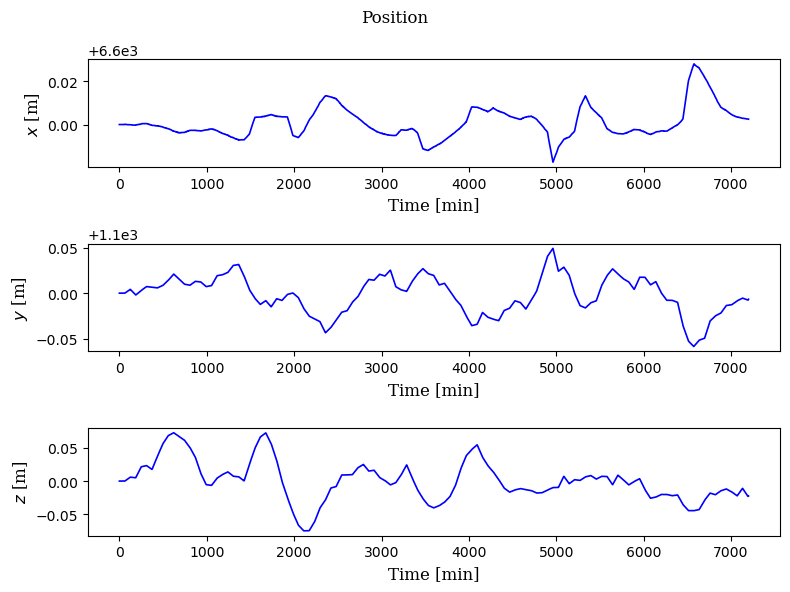

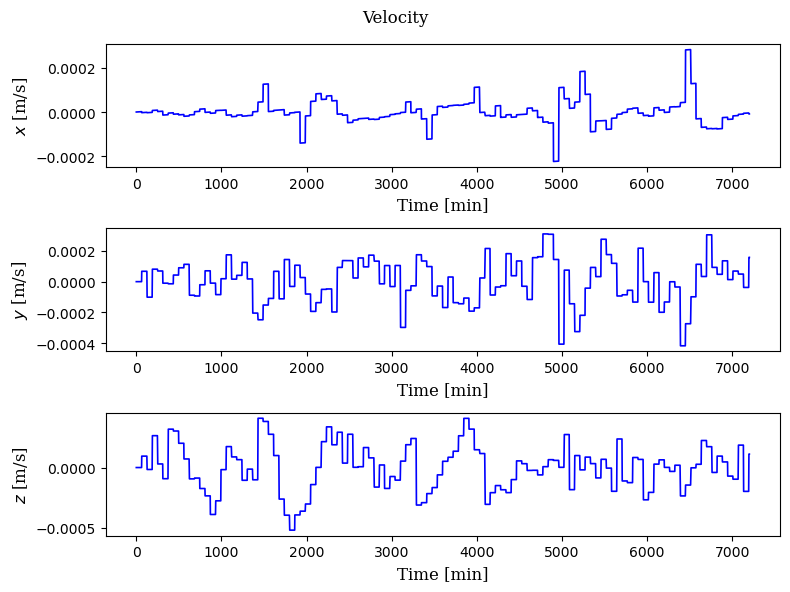

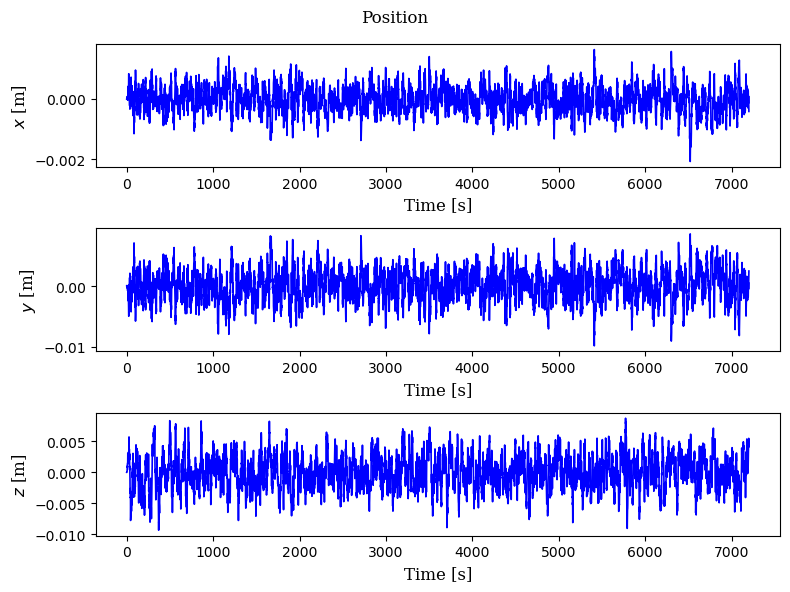

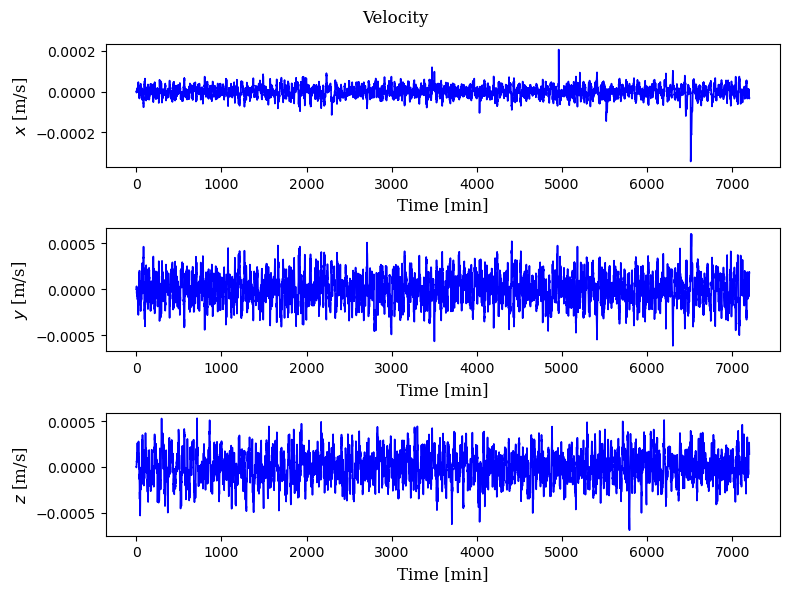

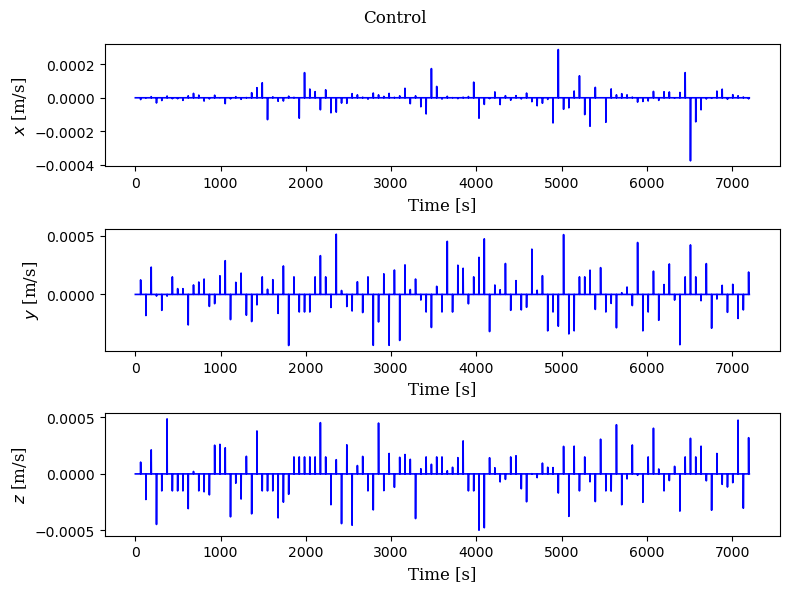

In [18]:
fig_dict_mpc = plot_results(sim_mpc, xdstyle, fontdict, r_units=("min", "m"), v_units=("min", "m/s"))
save_plots(fig_dict_mpc, "calibration_mpc", "calibration_cs")

In [19]:
def rmse(data, data_ref):
    rms = np.sqrt(((data-data_ref.reshape(-1,1))**2).sum(axis=1))

    return rms

def print_sequence(seq):
    
    a = "".join(" & " + "{:.2e}".format(num) for num in seq)

    print(a)


In [20]:
np.sqrt(((sim_lqr.report.relative_state[:3, :]-x_target[:3].reshape(-1,1))**2).sum(axis=1))

array([0.43234273, 0.64018584, 0.68268911])

In [21]:
np.sqrt((sim_lqr.report.relative_state[3:, :]**2).sum(axis=1))

array([0.00933515, 0.01328944, 0.01380912])

In [22]:
np.sqrt(((sim_mpc.report.relative_state[:3, :]-x_target[:3].reshape(-1,1))**2).sum(axis=1))

array([0.61377034, 1.74787294, 2.51381388])

In [23]:
np.sqrt((sim_mpc.report.relative_state[3:, :]**2).sum(axis=1))

array([0.00475694, 0.0118962 , 0.01602613])

In [24]:
sim_lqr.report.DV

2.466071433020469

In [25]:
sim_mpc.report.DV

0.04955363285803571

In [33]:
sim_mpc.report.DV * 6 * 6

1.7839307828892856

In [26]:
dat = (sim_mpc.report.relative_state[3:, :])

In [27]:
# plot_hist(dat[2,300:].flatten())

In [28]:
def Rc2s(u):
    v = u/np.linalg.norm(u)

    x, y, z = u

    theta = np.arctan2(np.sqrt(x**2 + y**2), z)
    phi = np.arctan2(y, x)

    R = np.array([[np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)],
                  [np.cos(theta) * np.cos(phi), np.cos(theta) * np.sin(phi), -np.sin(theta)],
                  [-np.sin(phi), np.cos(phi), 0]])

    return R

def spherical_error_core(r, r_tgt, r_point):

    _, b = r.shape

    dr_spherical = np.zeros_like(r)

    for i in range(b):
        dr = r[:, i] - r_tgt
        dr_spherical[:, i] = Rc2s(r_point) @ dr

    return dr_spherical

def spherical_error(r, r_tgt, r_point, plot=False, n=100, save=False, tag='default_', fontdict={}):

    dr_spherical = spherical_error_core(r, r_tgt, r_point)

    mu_d = dr_spherical[0].mean()
    std_d = dr_spherical[0].std()

    mu_lat_1 = dr_spherical[1].mean()
    std_lat_1 = dr_spherical[1].std()

    mu_lat_2 = dr_spherical[2].mean()
    std_lat_2 = dr_spherical[2].std()
    print(dr_spherical.shape)
    if plot:
        plot_hist(dr_spherical[0], n, save, tag + 'x', fontdict=fontdict, xlabel=r'$\epsilon_{v_x}$')
        plot_hist(dr_spherical[1], n, save, tag + 'y', fontdict=fontdict, xlabel=r'$\epsilon_{v_y}$')
        plot_hist(dr_spherical[2], n, save, tag + 'z', fontdict=fontdict, xlabel=r'$\epsilon_{v_z}$')

    return (mu_d, std_d), (mu_lat_1, std_lat_1), (mu_lat_2, std_lat_2)
    

def plot_hist(data, n=100, save=False, tag='default', fontdict={}, xlabel='x'):
    fig, ax = plt.subplots()
    fontdict['size'] = 15
    counts, bins, ignored = ax.hist(data, n, density=True)
    ax.set_ylabel('Probability density', fontdict=fontdict)
    # ax.set_xlabel(xlabel, fontdict=fontdict)
    mu = data.mean()
    sigma = data.std()

    ax.plot(bins, (1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mu)**2 / (2 * sigma**2) )),
            linewidth=2, color='r')
    
    # Adjust tick sizes
    ax.tick_params(axis='x', labelsize=14)  # Set x-axis tick size
    ax.tick_params(axis='y', labelsize=14)  # Set y-axis tick size

    fig.tight_layout()
    fontdict['size'] = 12
    plt.text(sigma*1.5, counts.max()*3/4, r'$\mu={:.2e}$'.format(mu).replace('e-0','e-') + "\n" + r'$\sigma={:.2e}$'.format(sigma).replace('e-0','e-'),fontdict=fontdict)

    if save:
        plt.savefig('calibration_final/'+ tag + '.pdf', format='pdf', dpi=300)
    


In [29]:
print("LQR")
print("\n")

print("Position error - cartesian")
print(rmse(sim_lqr.report.relative_state[:3, :], x_target[:3]))
print("\n")

print("Position error - spherical")

dr = spherical_error_core(sim_lqr.report.relative_state[:3, :], x_target[:3], x_target[:3])

print(rmse(dr, np.zeros(3)))
print("\n")

print("Velocity error - cartesian")
print(rmse(sim_lqr.report.relative_state[3:, :],  x_target[3:]))
print_sequence(rmse(sim_lqr.report.relative_state[3:, :],  x_target[3:]))
print("\n")

print("Velocity error - spherical")

dr = spherical_error_core(sim_lqr.report.relative_state[3:, :], x_target[3:], x_target[:3])

print(rmse(dr, np.zeros(3)))
print_sequence(rmse(dr, np.zeros(3)))

LQR


Position error - cartesian
[0.43234273 0.64018584 0.68268911]


Position error - spherical
[0.41718476 0.68268911 0.65016538]


Velocity error - cartesian
[0.00933515 0.01328944 0.01380912]
 & 9.34e-03 & 1.33e-02 & 1.38e-02


Velocity error - spherical
[0.00944839 0.01380912 0.01320917]
 & 9.45e-03 & 1.38e-02 & 1.32e-02


In [30]:
print("MPC")
print("\n")

print("Position error - cartesian")
print(rmse(sim_mpc.report.relative_state[:3, :], x_target[:3]))
print("\n")

print("Position error - spherical")

dr = spherical_error_core(sim_mpc.report.relative_state[:3, :], x_target[:3], x_target[:3])

print(rmse(dr, np.zeros(3)))
print("\n")

print("Velocity error - cartesian")
print(rmse(sim_mpc.report.relative_state[3:, :],  x_target[3:]))
print_sequence(rmse(sim_mpc.report.relative_state[3:, :],  x_target[3:]))
print("\n")

print("Velocity error - spherical")

dr = spherical_error_core(sim_mpc.report.relative_state[3:, :], x_target[3:], x_target[:3])

print(rmse(dr, np.zeros(3)))
print_sequence(rmse(dr, np.zeros(3)))

MPC


Position error - cartesian
[0.61377034 1.74787294 2.51381388]


Position error - spherical
[0.37764362 2.51381388 1.81360391]


Velocity error - cartesian
[0.00475694 0.0118962  0.01602613]
 & 4.76e-03 & 1.19e-02 & 1.60e-02


Velocity error - spherical
[0.00389147 0.01602613 0.01220674]
 & 3.89e-03 & 1.60e-02 & 1.22e-02


In [31]:
plot_hist(v_mpc_stack[0,:], fontdict=fontdict)

NameError: name 'v_mpc_stack' is not defined

In [ ]:
N = 10
ni = 10
dv_lqr = np.zeros(N)
dv_mpc = np.zeros(N)
tf = 100
error_lqr = np.zeros((3, int(tf) + 1, N))
error_mpc = np.zeros_like(error_lqr)
error_lqr_v = np.zeros_like(error_lqr)
error_mpc_v = np.zeros_like(error_lqr)
error_lqr_d = np.zeros((int(tf) + 1, N))
error_mpc_d = np.zeros_like(error_lqr_d)

error_lqr_lat = np.zeros((int(tf) + 1, N))
error_mpc_lat = np.zeros_like(error_lqr_lat)

r_lqr_stack = np.empty((3, 1))
v_lqr_stack = np.empty((3, 1))
v_lqr_stack_mean = np.zeros((3, N))

r_mpc_stack = np.empty((3, 1))
v_mpc_stack = np.empty((3, 1))
v_mpc_stack_mean = np.zeros((3, N))

pbar = tqdm(total=N)
for i in range(N):
    # Initial relative state [m, m/s]
    dx0 = np.array([100, 100, 100, 2*(np.random.random()-0.5)*1e-6, 2*(np.random.random()-0.5)*1e-6, 2*(np.random.random()-0.5)*1e-6])
    configOBC['X0'] = dx0
    configOBC['control_mode'] = 'LQR'
    sim_lqr_mc = run_analysis(x0, dx0, x_target, tf, dT, configOBC, configSim, cmd_seq=cmd_sequence, disable=True)
    configOBC['control_mode'] = 'MPC'
    sim_mpc_mc = run_analysis(x0, dx0, x_target, tf, dT, configOBC, configSim, cmd_seq=cmd_sequence, disable=True)
    dv_lqr[i] = sim_lqr_mc.report.DV
    dv_mpc[i] = sim_mpc_mc.report.DV
    # error_lqr[:, :, i] = sim_lqr.report.relative_state[:3, :] - x_target[:3].reshape(-1,1)
    # error_mpc[:, :, i] = sim_mpc.report.relative_state[:3, :] - x_target[:3].reshape(-1,1)
    # error_lqr_v[:, :, i] = sim_lqr.report.relative_state[3:, :]
    # error_mpc_v[:, :, i] = sim_mpc.report.relative_state[3:, :]

    # error_lqr_d[:, i] = np.linalg.norm(sim_lqr.report.relative_state[:3, :], axis=0) - np.linalg.norm(x_target[:3])
    # error_mpc_d[:, i] = np.linalg.norm(sim_mpc.report.relative_state[:3, :], axis=0) - np.linalg.norm(x_target[:3])

    # error_lqr_lat[:, i] = np.arccos(sim_lqr.report.relative_state[:3, :].T.dot(x_target[:3])/(np.linalg.norm(sim_lqr.report.relative_state[:3, :], axis=0) * np.linalg.norm(x_target[:3]))) * np.linalg.norm(sim_lqr.report.relative_state[:3, :], axis=0)
    # error_mpc_lat[:, i] = np.arccos(sim_mpc.report.relative_state[:3, :].T.dot(x_target[:3])/(np.linalg.norm(sim_mpc.report.relative_state[:3, :], axis=0) * np.linalg.norm(x_target[:3]))) * np.linalg.norm(sim_mpc.report.relative_state[:3, :], axis=0)
    r_lqr_stack = np.hstack((r_lqr_stack, sim_lqr_mc.report.relative_state[:3, ni:]))
    v_lqr_stack = np.hstack((v_lqr_stack, sim_lqr_mc.report.relative_state[3:, ni:]))
    v_lqr_stack_mean[:, i] = sim_lqr_mc.report.relative_state[3:, ni:].mean(axis=1)

    r_mpc_stack = np.hstack((r_mpc_stack, sim_mpc_mc.report.relative_state[:3, ni:]))
    v_mpc_stack = np.hstack((v_mpc_stack, sim_mpc_mc.report.relative_state[3:, ni:]))
    v_mpc_stack_mean[:, i] = sim_mpc_mc.report.relative_state[3:, ni:].mean(axis=1)

    pbar.update(1)
pbar.close

100%|██████████| 100/100 [2:32:30<00:00, 94.00s/it] 

<bound method tqdm.close of <tqdm.asyncio.tqdm_asyncio object at 0x0000021027ED62B0>>

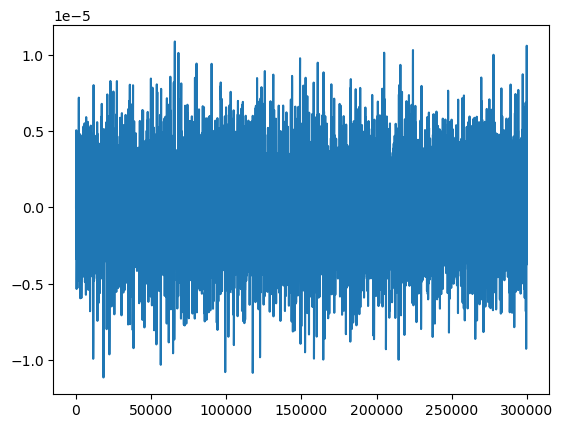

In [ ]:
plt.plot(v_mpc_stack[0,0:])

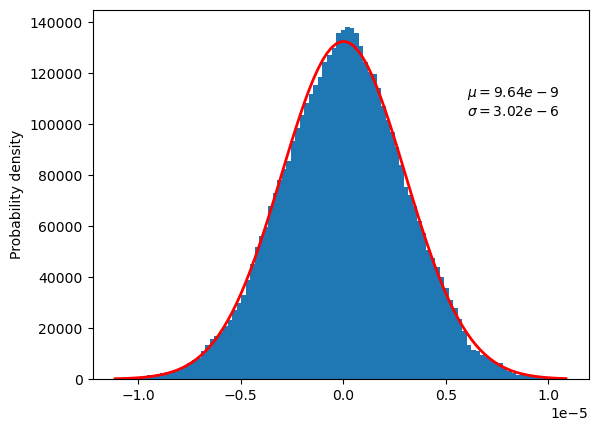

In [ ]:
plot_hist(v_mpc_stack[0,:])

(3, 300101)


((6.690647187812093e-09, 8.843083097997104e-07),
 (-4.626694122459549e-09, 3.973200522680064e-06),
 (-1.0840335587966588e-08, 2.9948329716318086e-06))

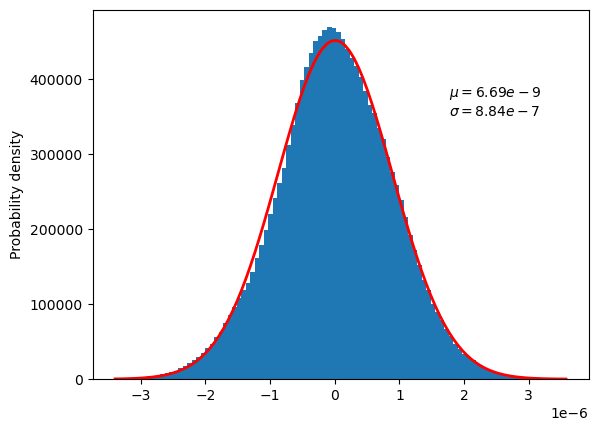

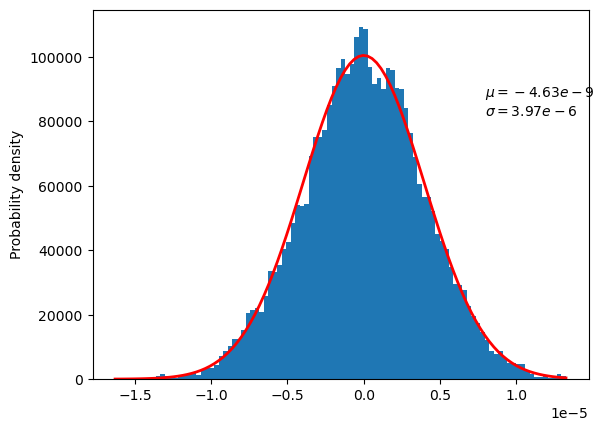

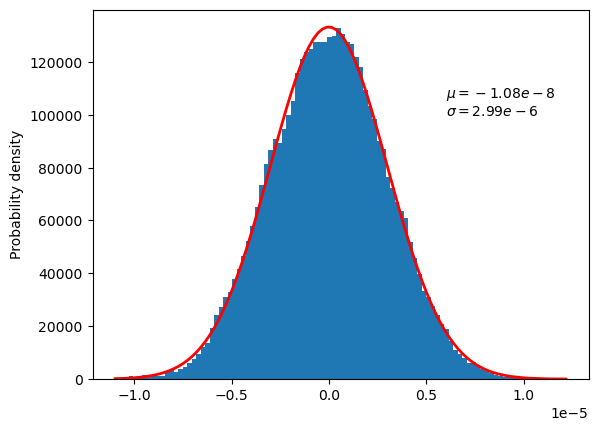

In [ ]:
spherical_error(v_mpc_stack, np.zeros(3), x_target[:3], True, 100)

(3, 300101)


((6.690647187812093e-09, 8.843083097997104e-07),
 (-4.626694122459549e-09, 3.973200522680064e-06),
 (-1.0840335587966588e-08, 2.9948329716318086e-06))

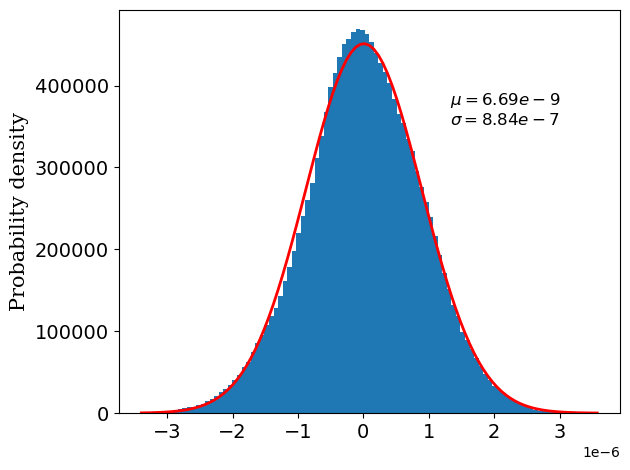

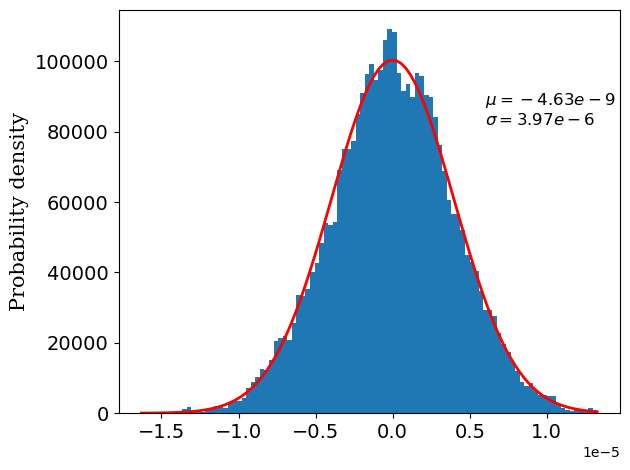

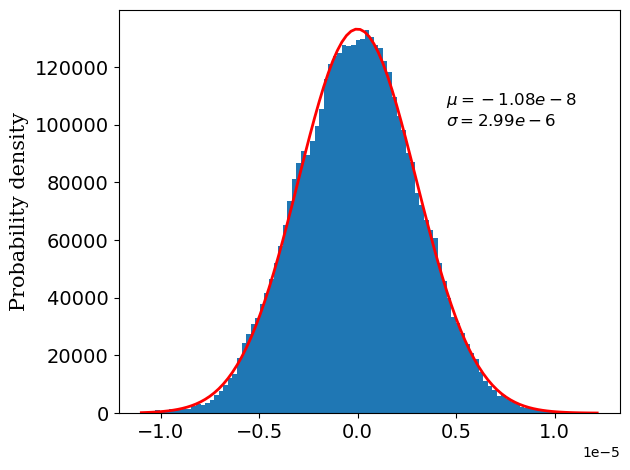

In [ ]:
spherical_error(v_mpc_stack, np.zeros(3), x_target[:3], True, 100, True, 'sigma_v', fontdict=fontdict)

(3, 50101)


((nan, nan), (nan, nan), (nan, nan))

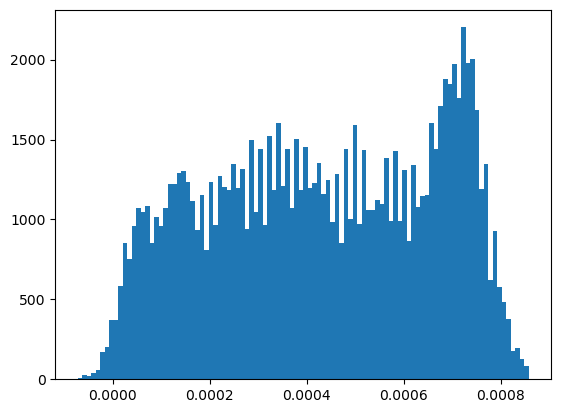

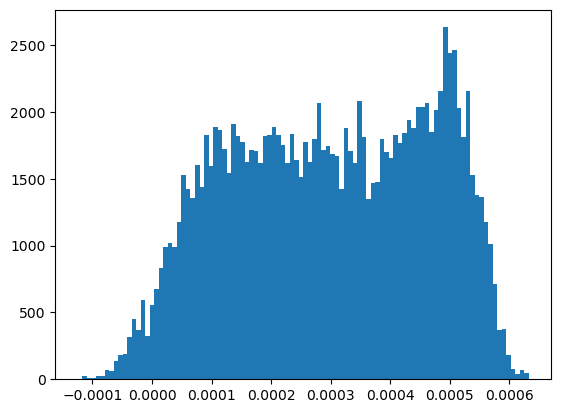

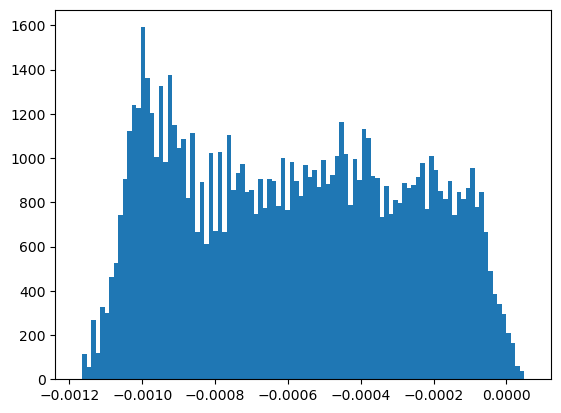

In [ ]:
spherical_error(r_mpc_stack, 100*np.ones(3), x_target[:3], True, 100, True, 'sigma_')

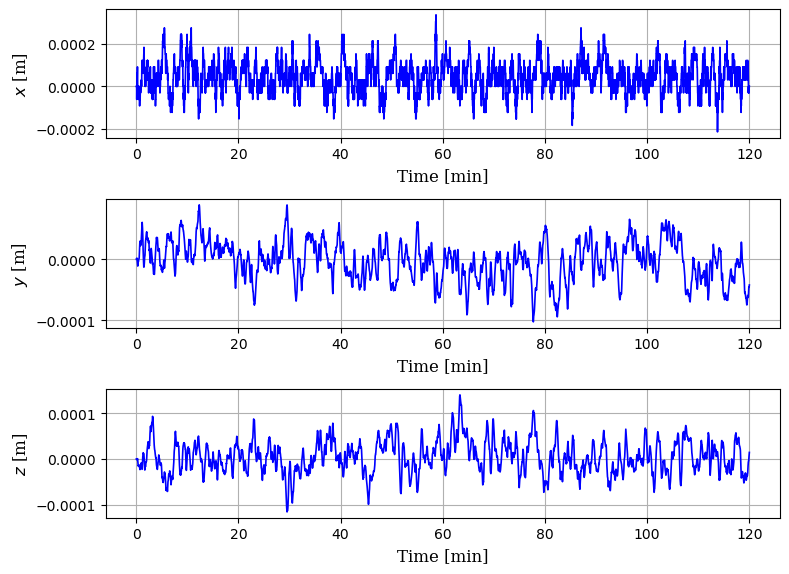

In [ ]:
fig, ax = plot_position(sim_lqr.report.time/60, sim_lqr.report.relative_state[:3,:]-100, xdstyle=xdstyle, fontdict=fontdict, units=("min", "m"))
fig.suptitle('')
fig.tight_layout()


for axis in ax:
    axis.grid()
#     axis.hlines([99.9, 100.1], sim_lqr.report.time[0]/60, sim_lqr.report.time[-1]/60, colors='k', linestyle='--', linewidth=1)

save_plots({'position_error':(fig, ax)}, "calibration_lqr", "calibration_cs_f")

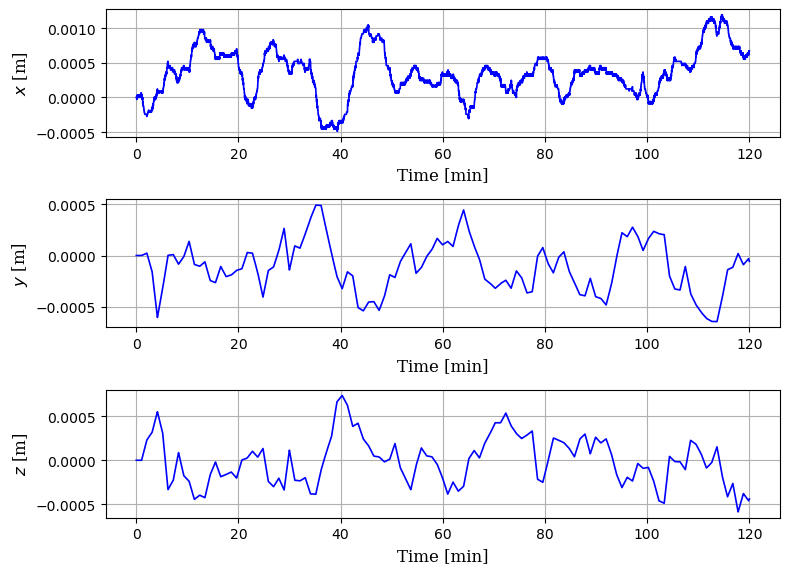

In [ ]:
fig, ax = plot_position(sim_mpc.report.time/60, sim_mpc.report.relative_state[:3,:]-100, xdstyle=xdstyle, fontdict=fontdict, units=("min", "m"))
fig.suptitle('')
fig.tight_layout()


for axis in ax:
    axis.grid()
#     axis.hlines([99.9, 100.1], sim_lqr.report.time[0]/60, sim_lqr.report.time[-1]/60, colors='k', linestyle='--', linewidth=1)

save_plots({'position_error':(fig, ax)}, "calibration_mpc", "calibration_cs_f")

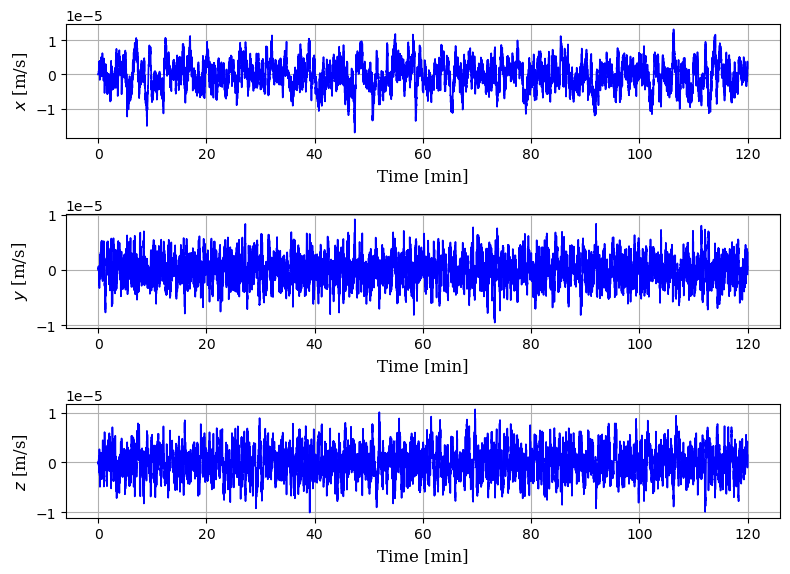

In [ ]:
fig, ax = plot_position(sim_lqr.report.time/60, sim_lqr.report.relative_state[3:,:], xdstyle=xdstyle, fontdict=fontdict, units=("min", "m/s"))
fig.suptitle('')
fig.tight_layout()


for axis in ax:
    axis.grid()
#     axis.hlines([99.9, 100.1], sim_lqr.report.time[0]/60, sim_lqr.report.time[-1]/60, colors='k', linestyle='--', linewidth=1)

save_plots({'velocity_error':(fig, ax)}, "calibration_lqr", "calibration_cs_f")

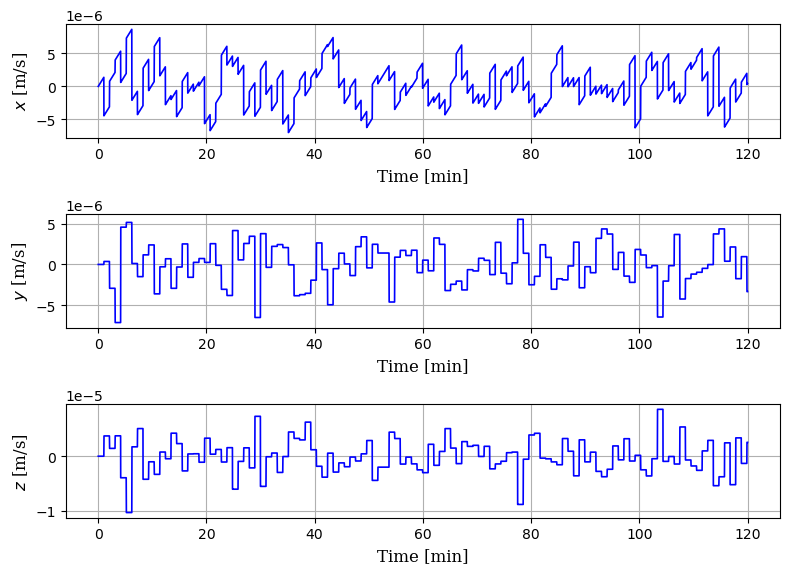

In [ ]:
fig, ax = plot_position(sim_mpc.report.time/60, sim_mpc.report.relative_state[3:, :], xdstyle=xdstyle, fontdict=fontdict, units=("min", "m/s"))
fig.suptitle('')
fig.tight_layout()


for axis in ax:
    axis.grid()
#     axis.hlines([99.9, 100.1], sim_lqr.report.time[0]/60, sim_lqr.report.time[-1]/60, colors='k', linestyle='--', linewidth=1)

save_plots({'velocity_error':(fig, ax)}, "calibration_mpc", "calibration_cs_f")

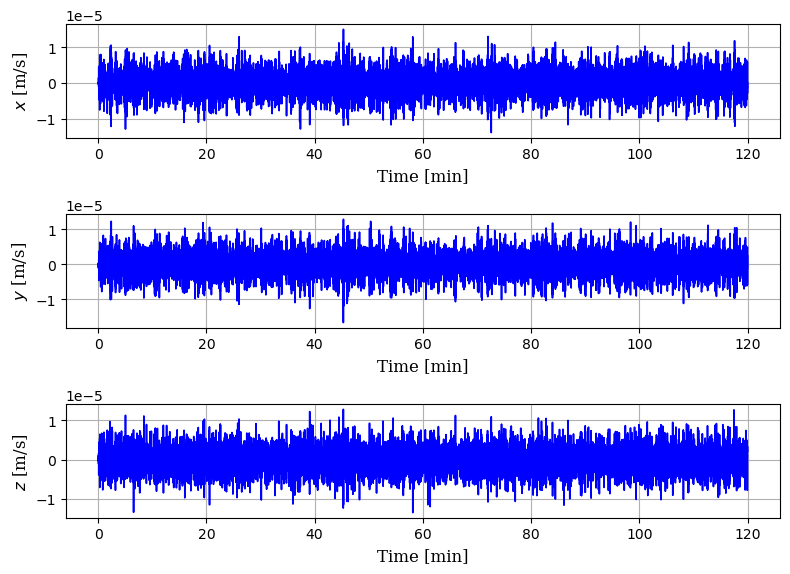

In [ ]:
fig, ax = plot_position(sim_lqr.report.time/60, sim_lqr.report.u_cmd, xdstyle=xdstyle, fontdict=fontdict, units=("min", "m/s"))
fig.suptitle('')
fig.tight_layout()


for axis in ax:
    axis.grid()
#     axis.hlines([99.9, 100.1], sim_lqr.report.time[0]/60, sim_lqr.report.time[-1]/60, colors='k', linestyle='--', linewidth=1)

save_plots({'control':(fig, ax)}, "calibration_lqr", "calibration_cs_f")

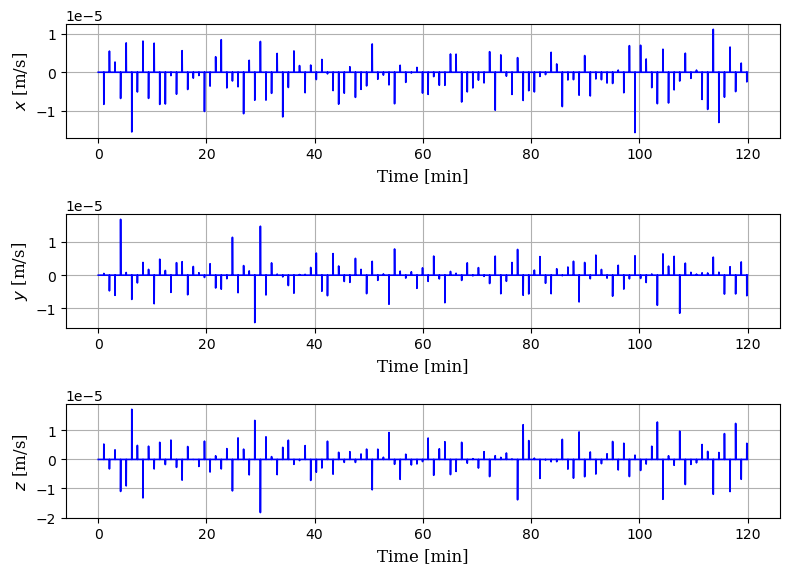

In [ ]:
fig, ax = plot_position(sim_mpc.report.time/60, sim_mpc.report.u_cmd, xdstyle=xdstyle, fontdict=fontdict, units=("min", "m/s"))
fig.suptitle('')
fig.tight_layout()


for axis in ax:
    axis.grid()
#     axis.hlines([99.9, 100.1], sim_lqr.report.time[0]/60, sim_lqr.report.time[-1]/60, colors='k', linestyle='--', linewidth=1)

save_plots({'control':(fig, ax)}, "calibration_mpc", "calibration_cs_f")